# **1. DATA PRE-PROCESSING AND VISUALIZATION**

In [150]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

sns.set_style("darkgrid")
%matplotlib inline

In [151]:
#Loading and Describing Data
data = pd.read_excel("/content/Home.LLC Exercise - Data.xlsx", skiprows=12, parse_dates=["Date"])
data.info()
print(data.describe())
data = data.set_index(['Date'])
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       240 non-null    datetime64[ns]
 1   HPI                        240 non-null    float64       
 2   New Housing                240 non-null    int64         
 3   Unemployment Rate          240 non-null    float64       
 4   CPI: Urban Housing         240 non-null    float64       
 5   Population (in Thousands)  240 non-null    int64         
 6   Disposable Income          240 non-null    int64         
 7   Mortgage Rate              240 non-null    float64       
 8   Supply                     240 non-null    float64       
 9   GDP (in $Billions)         240 non-null    float64       
dtypes: datetime64[ns](1), float64(6), int64(3)
memory usage: 18.9 KB
              HPI  New Housing  Unemployment Rate  CPI: Urban Housing

,HPI,New Housing,Unemployment Rate,CPI: Urban Housing,Population (in Thousands),Disposable Income,Mortgage Rate,Supply,GDP (in $Billions)
Date,,,,,,,,,
2003-01-01,128.460,1537,5.8,182.3,289412,35015,5.9160,4.0,13598.611629
2003-02-01,129.355,1301,5.9,183.2,289606,34867,5.8425,4.5,13658.896953
2003-03-01,130.147,1399,5.9,184.3,289809,34925,5.7450,4.1,13600.886856
2003-04-01,130.884,1374,6.0,184.1,290024,35105,5.8125,4.1,13675.625743
2003-05-01,131.734,1391,6.1,184.5,290250,35353,5.4840,3.9,13690.294541


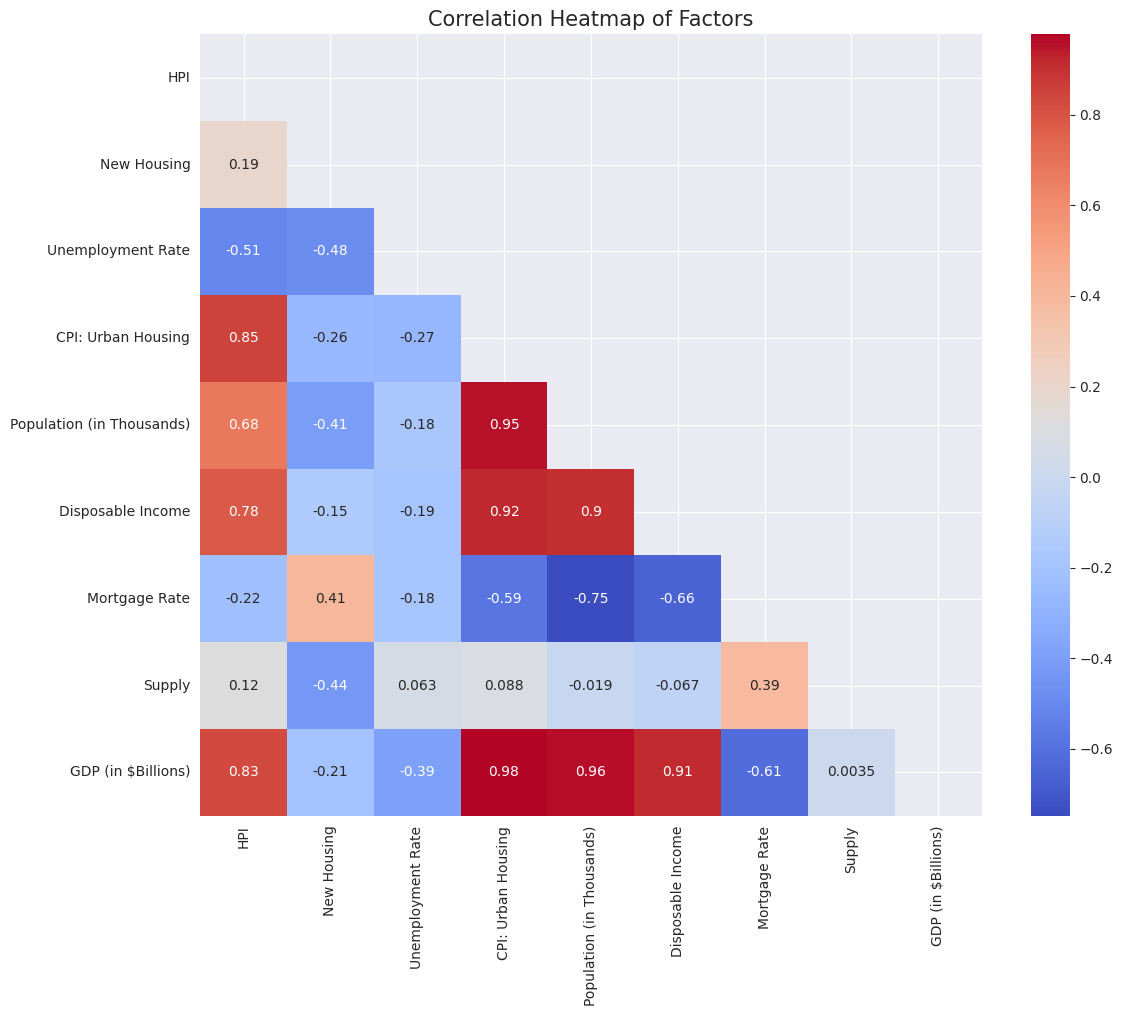

In [152]:
#Correlation Matrix
data_corr = data.corr()
mask = np.zeros_like(data_corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(12, 10))
    ax = sns.heatmap(data_corr, mask=mask, square=True, cmap='coolwarm', annot=True)
    plt.title('Correlation Heatmap of Factors', fontsize = 15)
    plt.yticks(rotation=0)
    plt.tight_layout()

**Observations:**

We see that there is a strong +ve linear relationship between HPI and each of GDP, CPI, Population, and Disposable Income.

We also see that HPI has a strong -ve linear relationship with Unemployment Rate.

Finally, there are stronger positive correlations between GDP and Population, and CPI and Disposable Income respectively which intuitively makes sense.

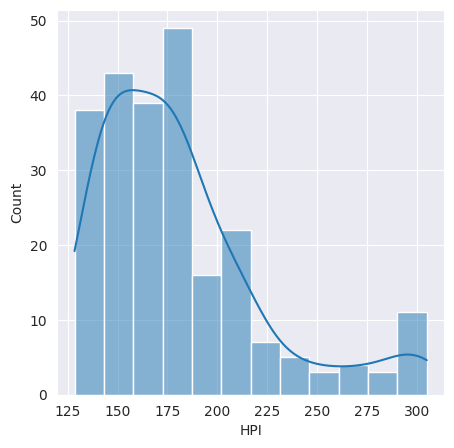

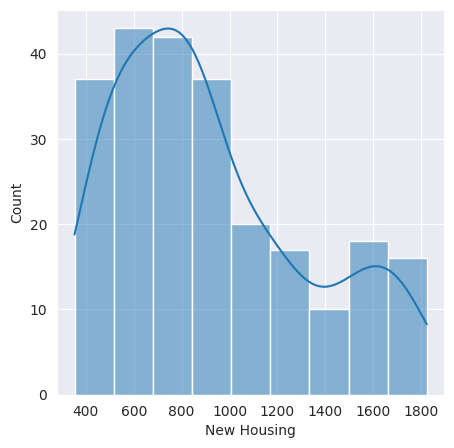

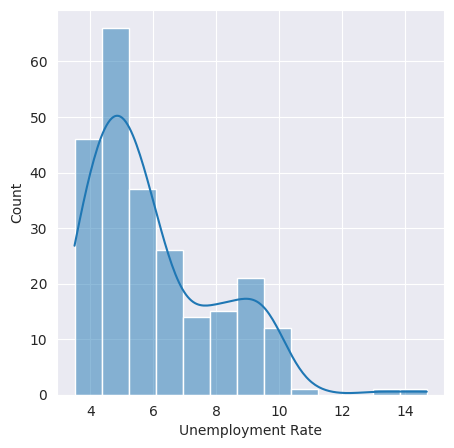

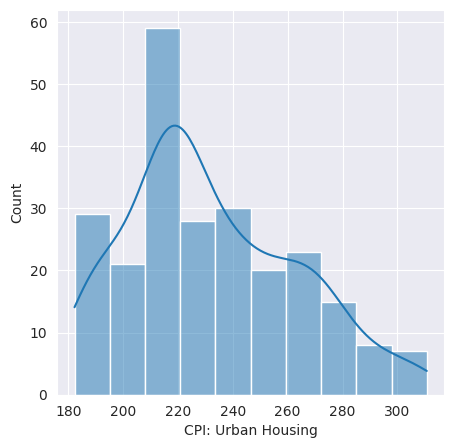

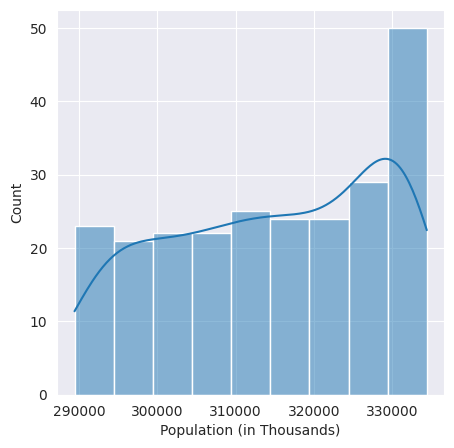

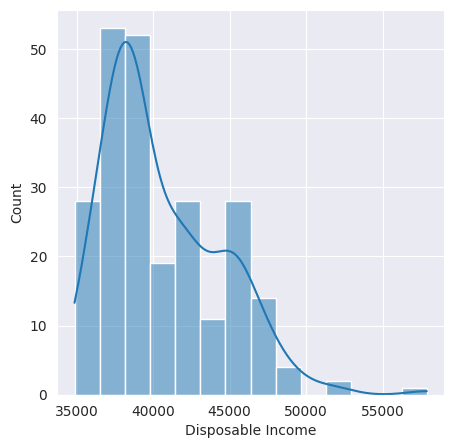

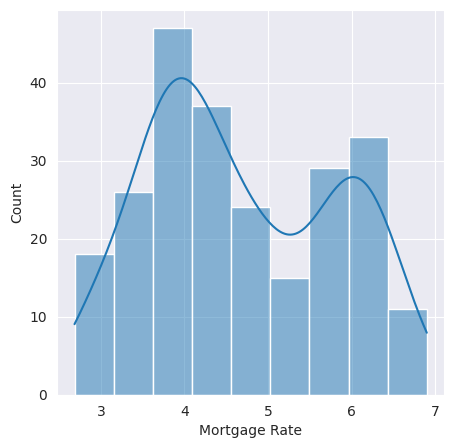

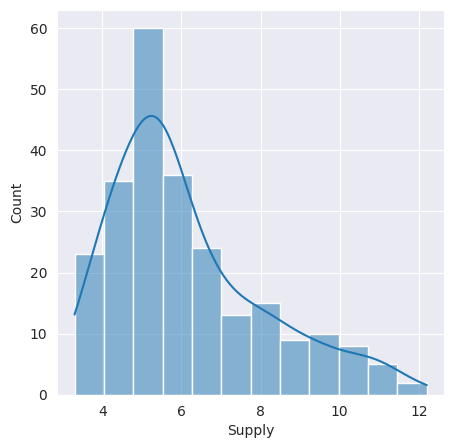

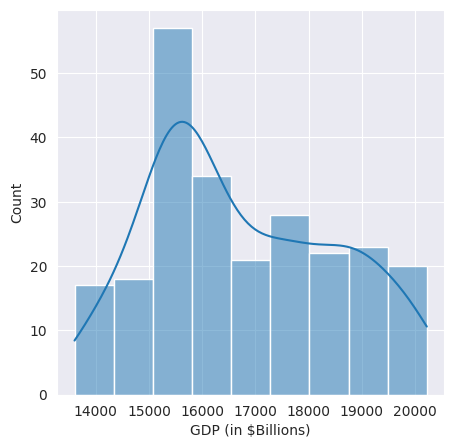

In [153]:
#EDA Visualizations (Distributions)
for feature in data:
  plt.figure(figsize=(5,5))
  sns.histplot(data[feature],kde=True)

Index(['HPI', 'New Housing', 'Unemployment Rate', 'CPI: Urban Housing',
       'Population (in Thousands)', 'Disposable Income', 'Mortgage Rate',
       'Supply', 'GDP (in $Billions)'],
      dtype='object')


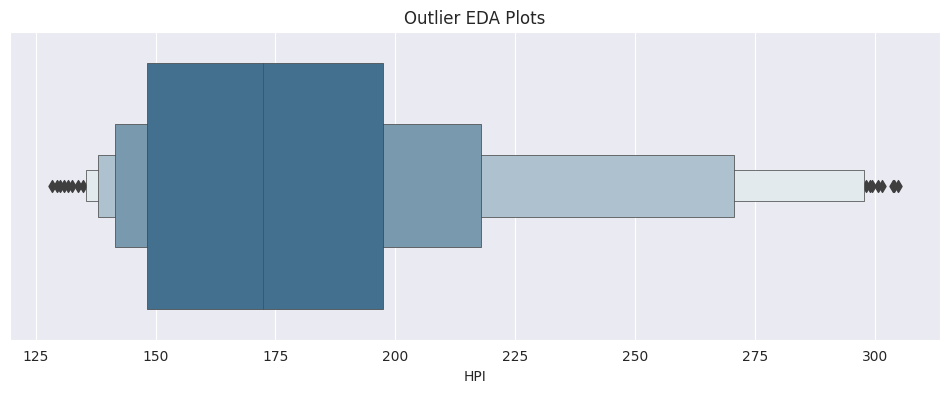

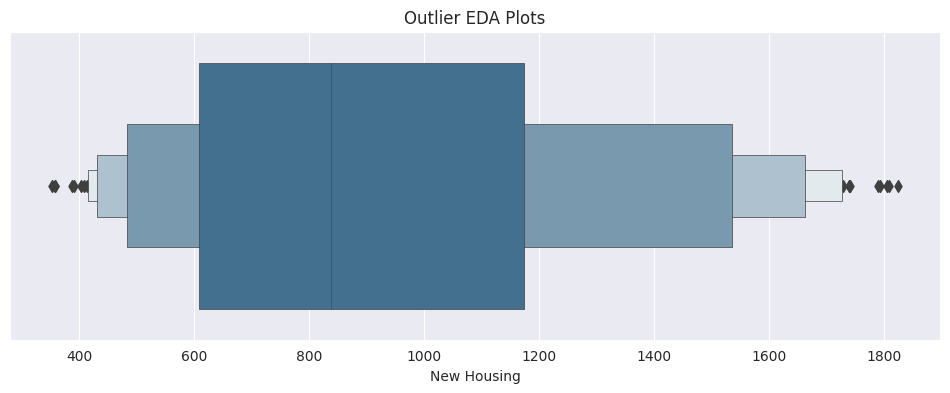

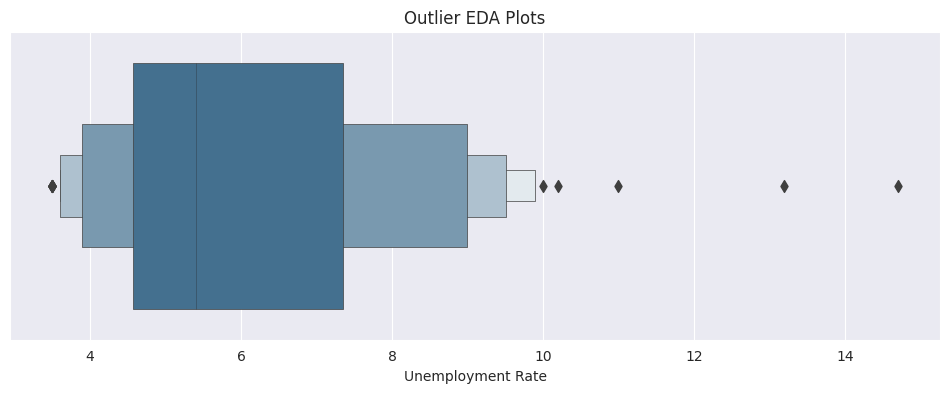

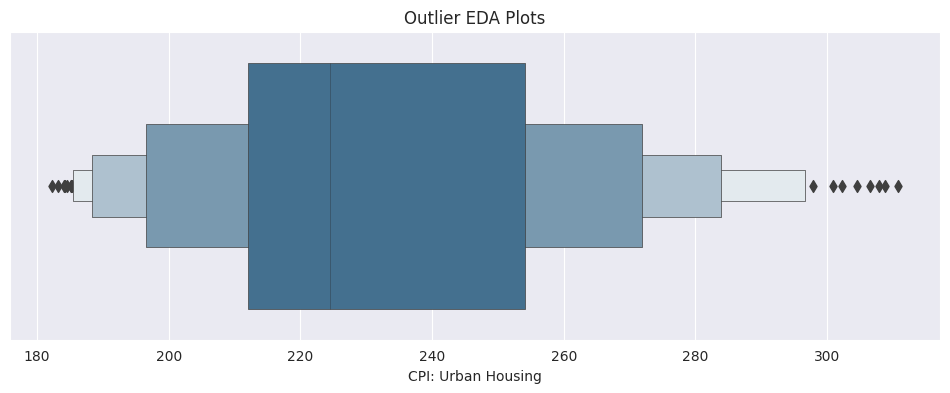

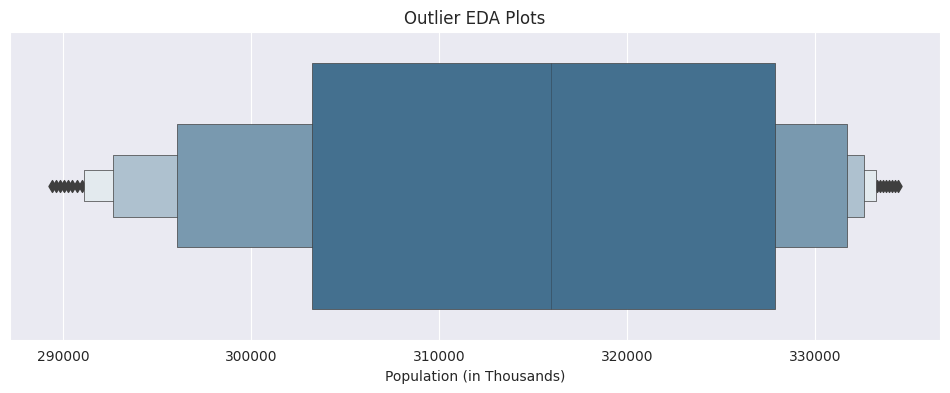

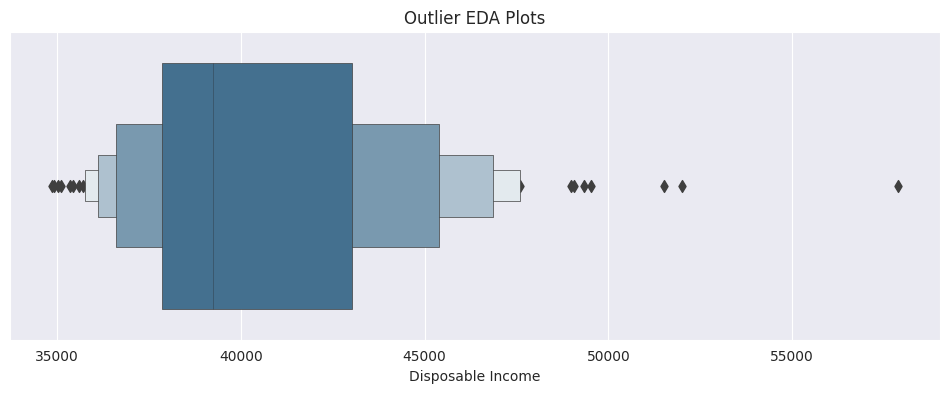

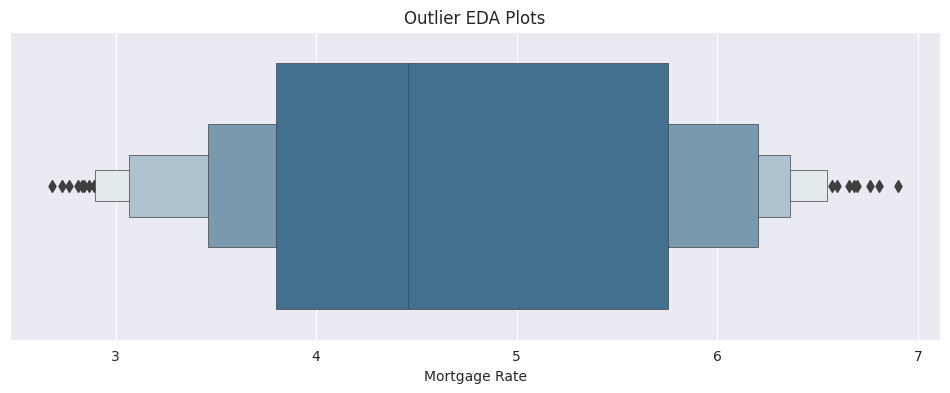

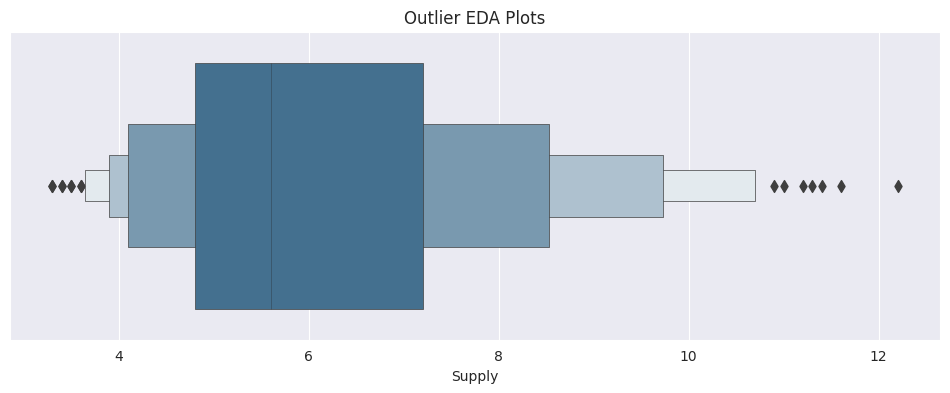

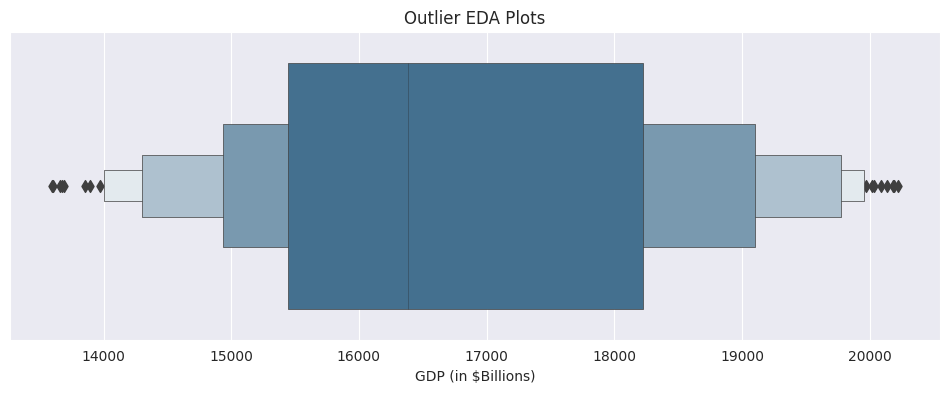

In [132]:
#EDA Visualizations (Outliers)
def plots(df, col):
  plt.figure(figsize=(12, 4))
  sns.boxenplot(x=col, data=data, linewidth=0.5, saturation=0.5)
  plt.xlabel(col)
  plt.title('Outlier EDA Plots')

columns = data.columns
print(columns)
for col in columns:
  plots(data, col)

**Observations:**

We see that all variables seem to be normally distributed with skews present in each of them as is expected in real-world data.

We can also see plenty of outliers in each variable. These outliers can be attributed either to the Great Recession (2007-09) or to the COVID-19 pandemic (2020-22). We are going to keep these outliers in our data as our values are adjusted for seasonality.

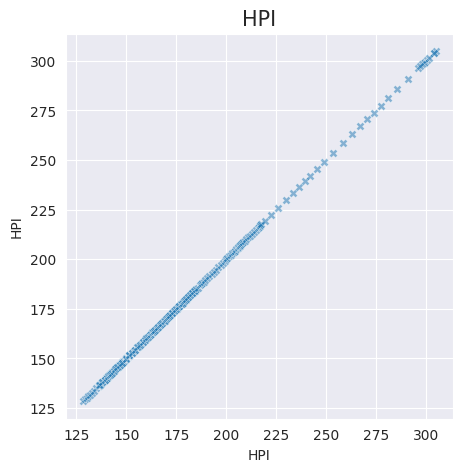

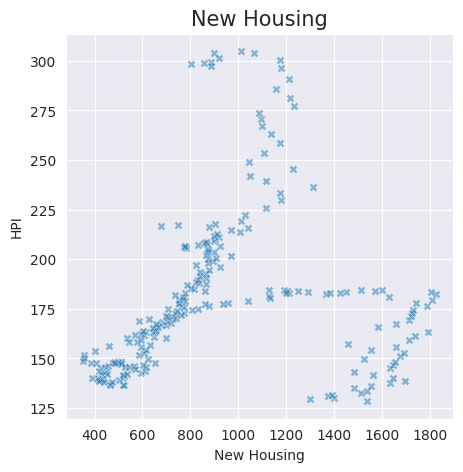

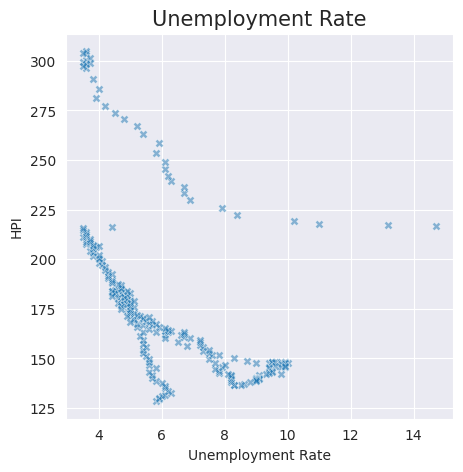

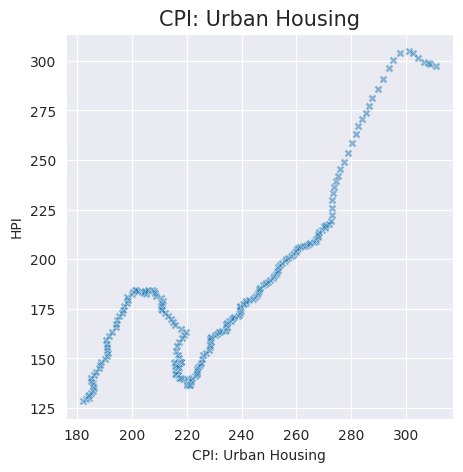

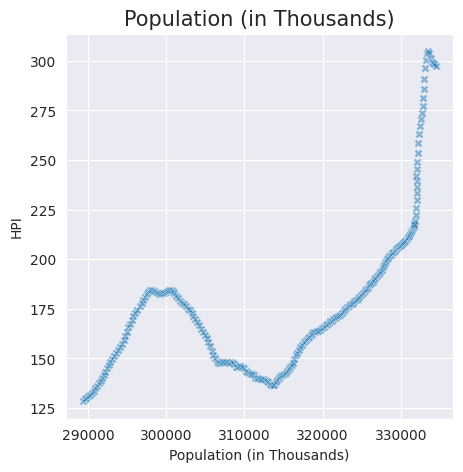

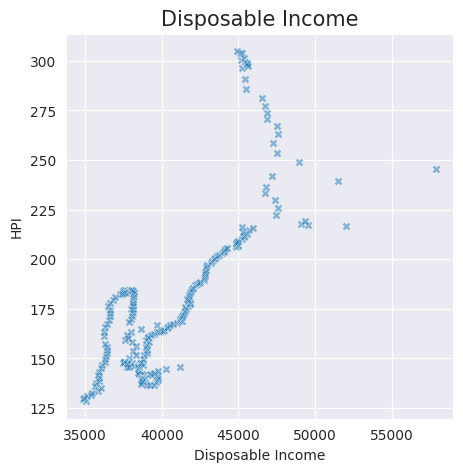

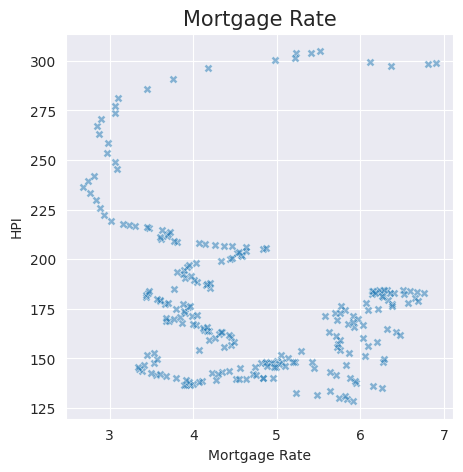

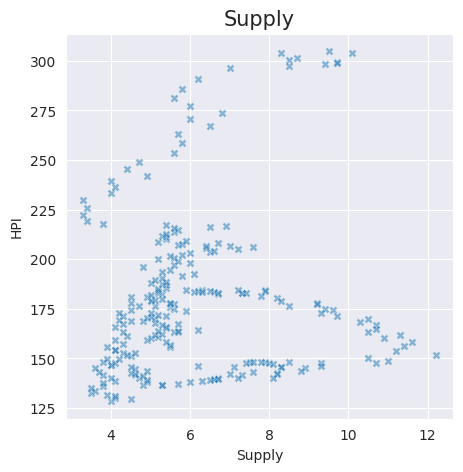

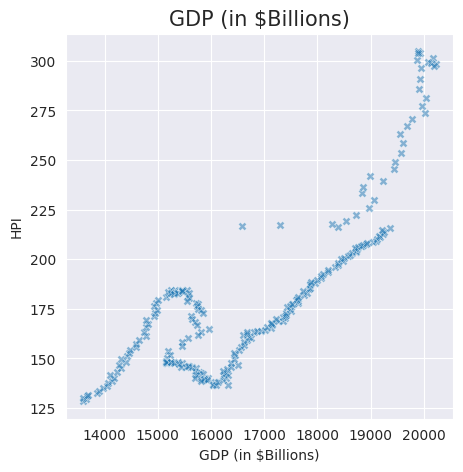

In [154]:
#EDA Visulizations (Relational Plots)
for feature in data:
  plt.figure(figsize=(5,5))
  sns.scatterplot(x=feature, y='HPI',data=data, marker="X", alpha=0.5)
  plt.xlabel(feature)
  plt.ylabel("HPI")
  plt.title(feature,fontsize=15)

**Observations:**

As Supply (The ratio of new houses available for sale to new houses already sold) rises (shifts), the supply increases and the price should fall (assuming demand stays constant). Yet, we see an overall trend of prices rising even though the supply increases.

More New Housing Projects getting approved is an indicator for the future that there is going to be an increase in Supply, which should lower current prices (assuming demand is constant). Yet, we see an overall trend of prices rising even though the supply increases.

These trends can only be attributed by a bigger rise (shift) in the demand for houses which is supported by other factors (Population, Disposable Income, CPI: Urban Housing, etc.) leading to a higher increase in demand.

According to the most recent estimates from Freddie Mac, the country is short about 3.8 million units of housing. This further illustrates the fact that even though the supply curve shifted to the right, our assumption of the demand being constant was wrong. The demand was constantly increasing too, on a much bigger scale. Hence, the housing prices were on a continuous rise as well.

# **2. DATA MODELING AND FORECASTING**

In [155]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as MSE

#Normalizing/Scaling
scaler = MinMaxScaler()
data_new = data.reset_index()
data_new = data_new.drop(columns=['Date'])
data_new_scaled = pd.DataFrame(scaler.fit_transform(data_new), columns = data_new.columns, index=data_new.index)
print(data_new_scaled.dropna().head())

#Split the dataset
## 'Disposable Income' was dropped to avoid the problem of multicollinearity with 'CPI: Urban Housing' as a large part of Disposable Incomes of US citizens went into buying houses, as per the calculation of 'CPI; Urban Housing'. (Information based on FRED Data, mentioned in the resources in the Presentation)
features = data_new_scaled.drop(['HPI', 'Disposable Income'], axis=1)
labels = data_new_scaled['HPI']
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=10)

        HPI  New Housing  Unemployment Rate  CPI: Urban Housing  \
0  0.000000     0.805442           0.205357            0.000000   
1  0.005075     0.644898           0.214286            0.007008   
2  0.009566     0.711565           0.214286            0.015573   
3  0.013745     0.694558           0.223214            0.014016   
4  0.018565     0.706122           0.232143            0.017131   

   Population (in Thousands)  Disposable Income  Mortgage Rate    Supply  \
0                   0.000000           0.006433       0.766603  0.078652   
1                   0.004310           0.000000       0.749170  0.134831   
2                   0.008821           0.002521       0.726044  0.089888   
3                   0.013598           0.010346       0.742054  0.089888   
4                   0.018619           0.021126       0.664137  0.067416   

   GDP (in $Billions)  
0            0.000000  
1            0.009105  
2            0.000344  
3            0.011631  
4            0.01384

{'whiskers': [<matplotlib.lines.Line2D at 0x7d3f2de25e40>,
 'caps': [<matplotlib.lines.Line2D at 0x7d3f2760e500>,
 'boxes': [<matplotlib.lines.Line2D at 0x7d3f2de241f0>,
 'medians': [<matplotlib.lines.Line2D at 0x7d3f2760ece0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7d3f2760e860>,
 'means': [<matplotlib.lines.Line2D at 0x7d3f2760d810>,
  <matplotlib.lines.Line2D at 0x7d3f2dc77ca0>]}

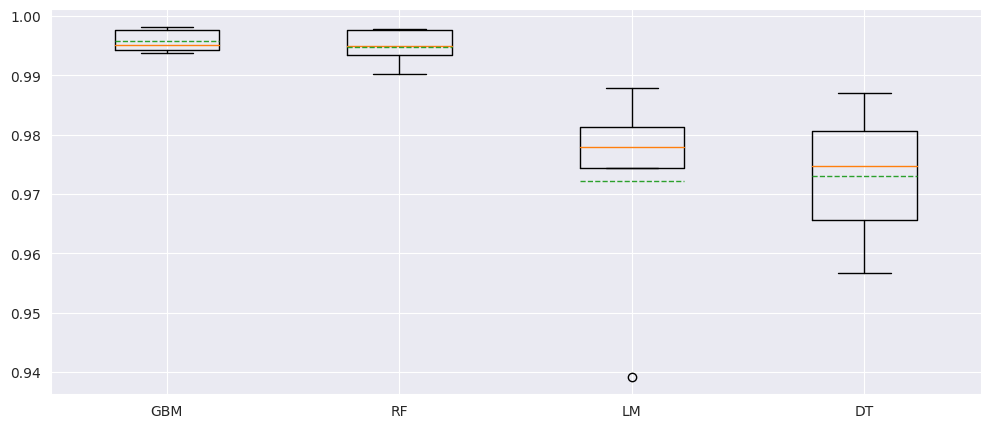

In [165]:
#Setting up the model
models = {'GBM':GradientBoostingRegressor(n_estimators=100), 'RF':RandomForestRegressor(), 'LM':LinearRegression(), 'DT':DecisionTreeRegressor(max_depth=5)}
cv_scores = []
kf = KFold(n_splits=5, shuffle=True, random_state=199)
for model in models.values():
  cv_results = cross_val_score(model, train_features, train_labels, cv=kf, scoring='r2')
  cv_scores.append(cv_results)

# Plot model performance
plt.figure(figsize=(12,5))
plt.clf()
plt.boxplot(cv_scores, labels=models.keys(), showmeans=True, meanline=True)

**We chose the GBM model as our main model due to its R-square scores across different CV-sets.**

In [122]:
#Hyperparameter Tuning
param_grid = {'n_estimators':np.linspace(start = 200, stop = 2000, num = 10, dtype='int64'), 'max_features':['auto', 'sqrt'], 'max_depth':np.linspace(10, 110, num = 11, dtype='int64'), 'min_samples_leaf':[1, 2, 4]}
kf = KFold(n_splits=5, shuffle=True, random_state=199)
final_model = RandomizedSearchCV(GradientBoostingRegressor(), param_grid, cv=kf)
final_model.fit(train_features, train_labels)
y_pred = final_model.predict(test_features)
score = final_model.score(test_features, test_labels)
rmse = MSE(test_labels, y_pred, squared=False)
print('Tuned Model Parameters: {}, Tuned Model CV-Score: {}, Chosen Model R-squared Score:{}, Chosen Model RMSE:{}'.format(final_model.best_params_, final_model.best_score_, score, rmse))

Tuned Model Parameters: {'n_estimators': 400, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 40}, Tuned Model CV-Score: 0.9972763811155048, Chosen Model R-squared Score:0.9948373130200279, Chosen Model RMSE:0.013233528604454675


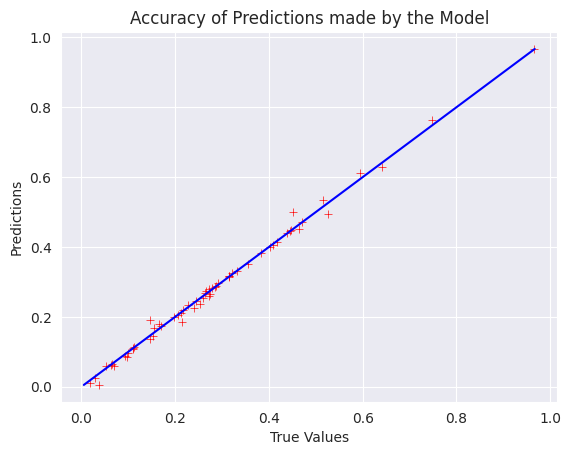

Text(0.5, 1.0, 'Feature Importances')

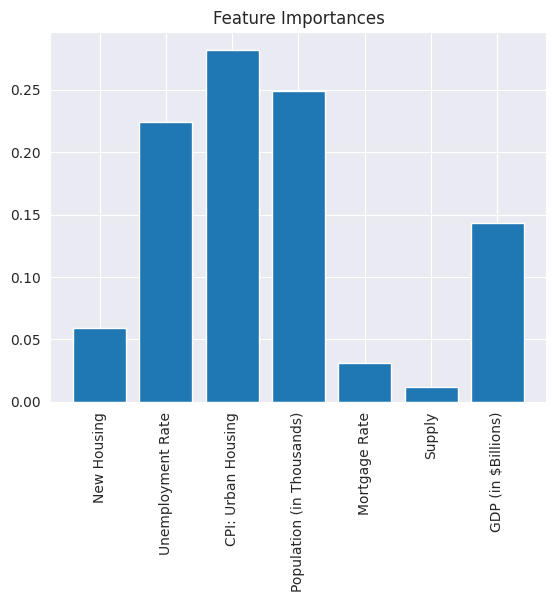

In [166]:
#Validating Predictions
sns.scatterplot(x=y_pred, y=test_labels, c='red', marker='+')
p1 = max(max(y_pred), max(test_labels))
p2 = min(min(y_pred), min(test_labels))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Accuracy of Predictions made by the Model')
plt.show()

#Selecting Features
plt.clf()
plt.bar(train_features.columns, final_model.best_estimator_.feature_importances_)
plt.xticks(rotation=90)
plt.title('Feature Importances')

**Thus, we can observe that our selected model seems to have performed very well. The R-squared score of the model is very high ~ 99% and the predictions seem to be in line with the Test-Set values.**


# **3. OLS MODEL EXPLAINING THE FACTORS AND THEIR EFFECTS ON HPI**

                                 OLS Regression Results                                
Dep. Variable:                    HPI   R-squared (uncentered):                   0.991
Model:                            OLS   Adj. R-squared (uncentered):              0.990
Method:                 Least Squares   F-statistic:                              2582.
Date:                Tue, 26 Sep 2023   Prob (F-statistic):                   2.14e-171
Time:                        22:20:39   Log-Likelihood:                          333.59
No. Observations:                 180   AIC:                                     -653.2
Df Residuals:                     173   BIC:                                     -630.8
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

Text(0.5, 1.0, 'Homoskedasticity Check')

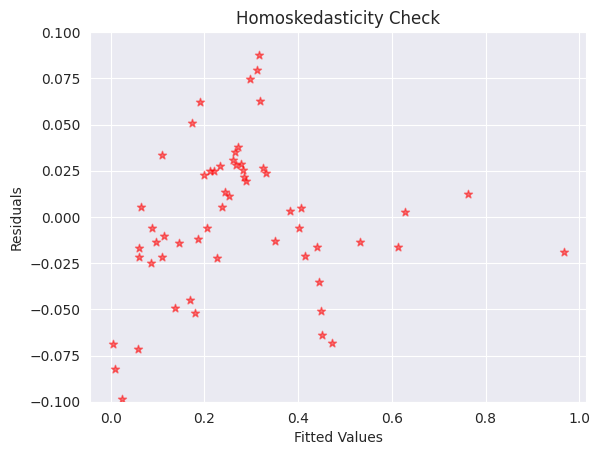

In [160]:
#OLS Estimation to explain the impact of Factors/Features on HPI
import statsmodels.api as sm
result = sm.OLS(train_labels, train_features).fit()
print(result.summary())

y_pred_ols = result.predict(test_features)
residuals = test_labels-y_pred_ols
plt.scatter(test_labels, residuals, alpha=0.5, marker='*', c='r')
plt.ylim(-0.1, 0.1)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Homoskedasticity Check')

In [161]:
print(cv_scores)

[array([0.99771454, 0.99902256, 0.99534818, 0.99442977, 0.99101885]), array([0.99741554, 0.99566213, 0.99316787, 0.99352355, 0.99027036]), array([0.97437439, 0.9878753 , 0.93918664, 0.98133271, 0.97791268]), array([0.98793142, 0.98037955, 0.95476028, 0.97329604, 0.96635719])]
